### Exploratory and Statistical Analysis of the GoFast Scooter Rental Service  

**This project analyzes data about some users from several cities, as well as their trips.**

GoFast users access the service through a mobile app.

**Service options:**
* Without subscription:  
  - No monthly fee  
  - Cost per minute — 8 RUB  
  - Start fee — 50 RUB  

* With Ultra subscription:  
  - Monthly fee — 199 RUB  
  - Cost per minute — 6 RUB  
  - Start fee — free  

**Data sources:**  
1) /datasets/users_go.csv  
2) /datasets/rides_go.csv  
3) /datasets/subscriptions_go.csv  

**Research goals:**  
1. Describe general information about users, trips, and cities.  
2. Compare users with and without a subscription.  
3. Calculate revenue from both categories.  
4. Test statistical hypotheses about revenue.  

In [3]:
from scipy import stats as st
from math import factorial
from scipy.stats import binom
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Step 1. Data Loading

In [6]:
try:
    user_df = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
except:
    pass

In [7]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [8]:
user_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [11]:
try:
    rides_df = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
except:
    pass

In [12]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [13]:
rides_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [16]:
try:
    subs_df = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
except:
    pass

In [17]:
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [18]:
subs_df.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Conclusion:**  
1. The datasets on users and trips are roughly equal in size.  
2. The trips table mainly contains numerical data, except for dates, which need to be converted to the proper format.  
3. Text data in the users dataset is written with capital letters.  

#### Step 2. Data Preprocessing

##### Check dataframes for obvious duplicates and missing values:

In [19]:
# check for duplicates
user_df.duplicated().sum()

31

In [20]:
# check the maximum number of duplicated rows to see if this is just ordinary duplication
user_df['user_id'].value_counts().max()

2

In [21]:
# remove duplicates
user_df = user_df.drop_duplicates().reset_index(drop
= True)

In [22]:
# check that duplicates were removed
user_df.duplicated().sum()

0

In [23]:
# check for missing values
user_df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [24]:
# check for duplicates
rides_df.duplicated().sum()

0

In [25]:
# check for missing values
rides_df.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [26]:
# convert the date column to the correct type
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y.%m.%d')

In [27]:
# check data types
rides_df['date'].dtype

dtype('<M8[ns]')

In [28]:
rides_df['date'].dt.month.unique()

array([ 1,  4,  8, 10, 11, 12,  3,  6,  7,  2,  5,  9])

In [29]:
rides_df['date'].dt.year.unique()

array([2021])

In [30]:
rides_df['month'] = rides_df['date'].dt.month

In [31]:
# add a column to the trips dataframe with speed (meters per minute converted to km/h)
rides_df['speed'] = (rides_df['distance']/rides_df['duration']) *  0.06

In [32]:
rides_df['duration'] = np.ceil(rides_df['duration']) 

##### Conclusion for this section:
1. The users dataset was cleaned from duplicates (less than 1%). No missing values were found.  
2. The trips dataset contains no duplicates or missing values.  
3. The trips dataset had its date column converted to datetime type.  
4. The dataset includes trip data over a time period.  

#### Step 3. Exploratory Data Analysis

##### Consider the cities where the service is most popular:

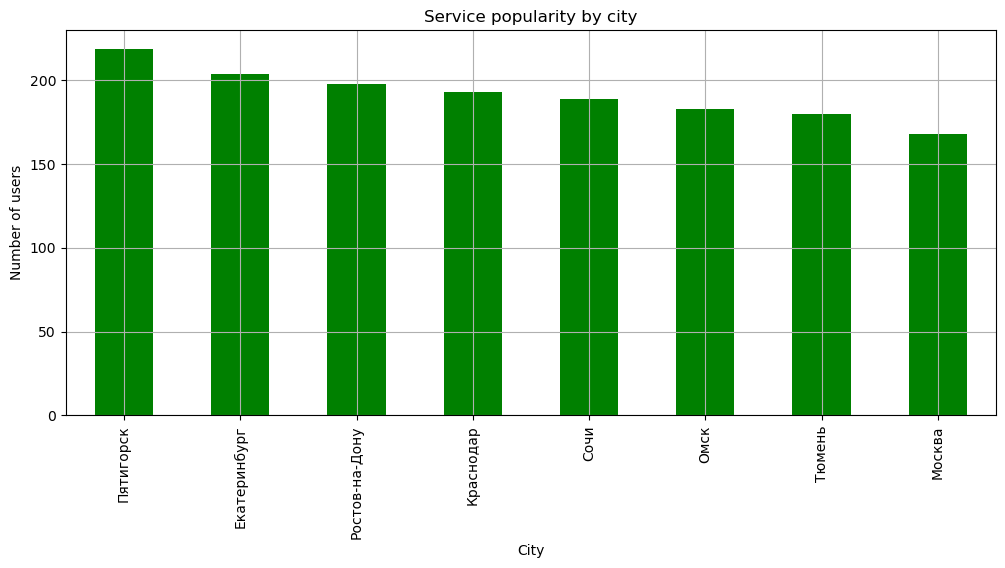

In [33]:
(user_df['city']
 .value_counts()
 .plot(grid=True, figsize=(12, 5),
       kind='bar', title='Service popularity by city', color=['green'],
       ylabel="Number of users",
       xlabel="City")
);

**Conclusion:**

1. There is no city where the service is significantly more popular.  
2. The service is used by Pyatigorsk users 4% more than in Moscow.  
   Likely, there are more competing services in the capital.  

##### Consider the ratio of users with and without a subscription:

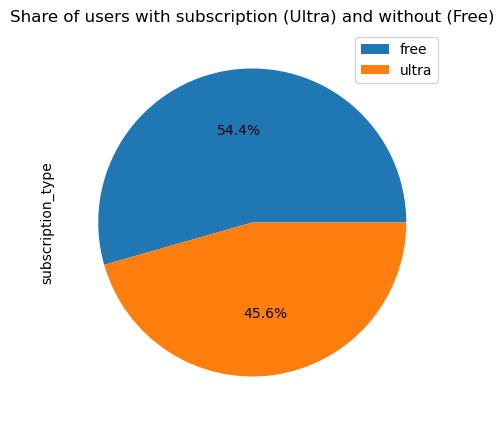

In [34]:
(
    user_df['subscription_type']
    .value_counts()
    .plot(
        kind='pie',
        figsize=(12, 5),
        autopct='%1.1f%%',
        title='Share of users with subscription (Ultra) and without (Free)',
        legend=True,
        labeldistance=None
    )
);

**Conclusion:**  

1. Users without a subscription make up 54%, while users with a subscription account for 45%.  
2. It cannot be said unambiguously whether the service is mainly for one-time use or for regular use.  
3. The service has a fairly large base of regular customers.  

##### Consider the age of users:

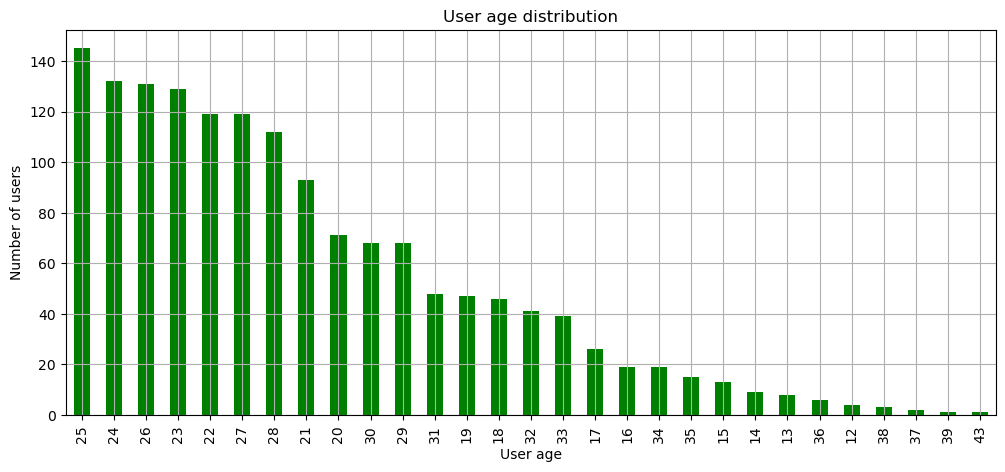

In [35]:
(user_df['age']
 .value_counts()
 .plot(kind='bar',
       grid=True,
       ylabel="Number of users",
       xlabel="User age",
       figsize=(12, 5),
       title='User age distribution',
       color=['green'])
);

**Conclusion:**  

1. The most common age group is 24–26 years.  
2. The least common age group is 36+.  

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


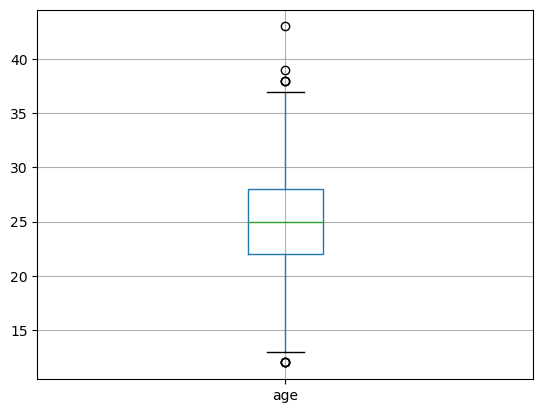

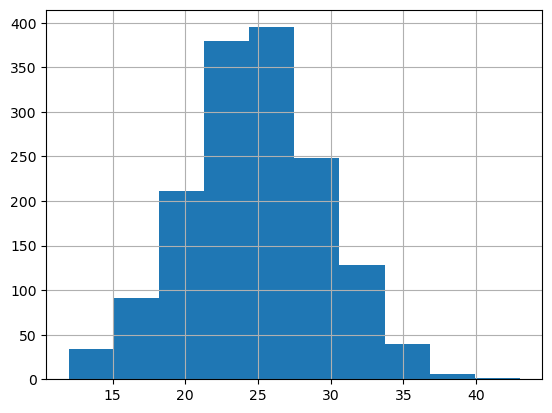

In [36]:
print(user_df['age'].describe());
user_df.boxplot('age');
plt.show();
user_df['age'].hist();

**Conclusion:**  

1. The age distribution looks normal. Most users are between 22 and 28 years old. Median: 25 years.  
2. Outliers are rare.  

In [37]:
# check if there is a noticeable relationship between subscription type and age
user_df.pivot_table(index='subscription_type',values='age', aggfunc=['median','count'])

,median,count
,age,age
subscription_type,,
free,25,835
ultra,25,699


##### Consider the trip data:

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


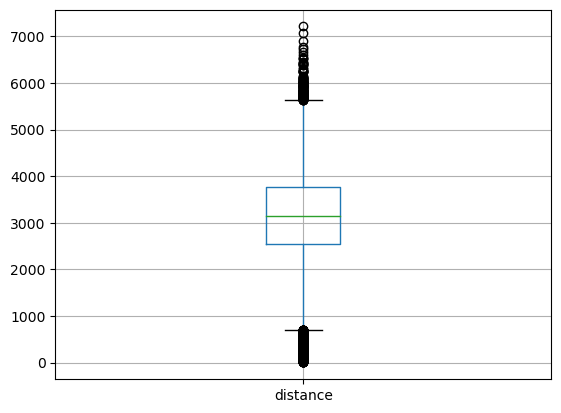

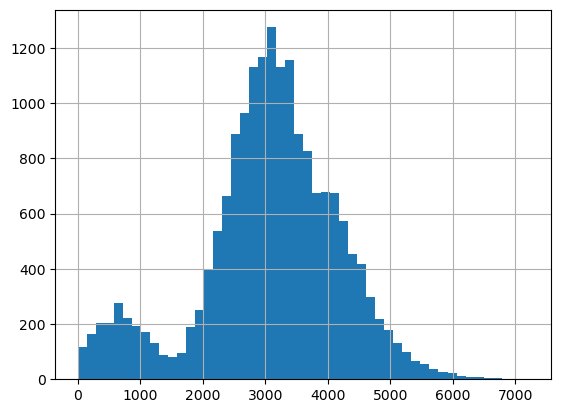

In [38]:
print(rides_df['distance'].describe())
rides_df.boxplot('distance');
plt.show();
rides_df['distance'].hist(bins=50);

**Conclusion:**  

1. The histogram shows two peaks: at 3 km and 500 m.  
2. Most trips are between 2500 and 3800 meters. Median: 3133 meters.  
3. Some users take short trips — up to 1500 m.  
4. Trips longer than 5 km are rare.  
5. Maximum distance: 7 km.  

Look at the trip duration histogram:

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64


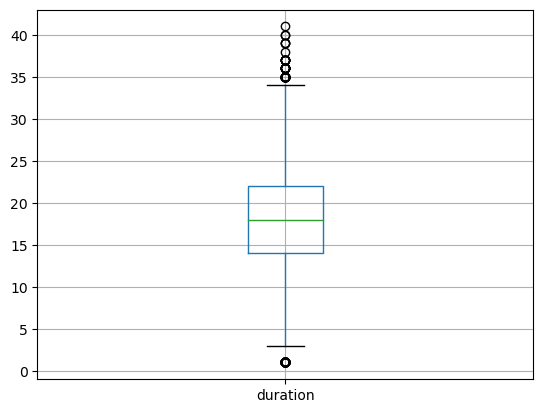

<Axes: >

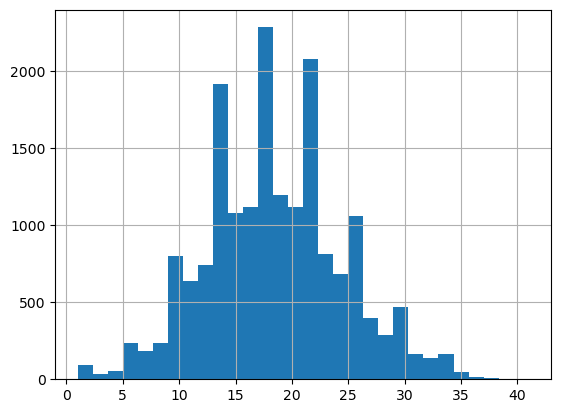

In [39]:
print(rides_df['duration'].describe())
rides_df.boxplot('duration');
plt.show();
rides_df['duration'].hist(bins=30)

**Conclusion:**  

1. The distribution looks normal; on average, a trip lasts 18 minutes.  
2. Users rarely ride longer than 30 minutes per trip. This looks plausible.  
3. Outliers exist mostly at the upper bound but are isolated cases.  

Take a closer look at short trips.

<Axes: >

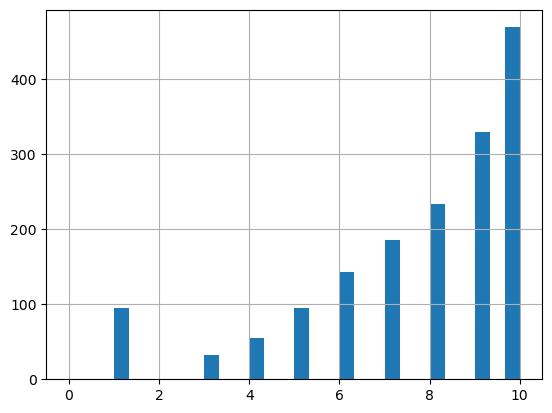

In [40]:
rides_df['duration'].hist(range=(0,10),bins=30)

There is a strange peak around 0.5 minutes. This is likely due to users changing their mind and ending the trip right after starting.  

In [41]:
rides_df.query('duration < 3').sort_values(by='duration')

,user_id,distance,duration,date,month,speed
6531,701,4196.445201,1.0,2021-08-31,8,503.573424
14615,1287,5944.789947,1.0,2021-12-09,12,713.374794
14574,1285,6316.574814,1.0,2021-09-25,9,757.988978
14417,1273,4178.876258,1.0,2021-04-30,4,501.465151
14342,1268,4177.139336,1.0,2021-06-09,6,501.256720
...,...,...,...,...,...,...
9581,928,4857.412920,1.0,2021-06-06,6,582.889550
9497,922,4620.899239,1.0,2021-01-05,1,554.507909
9282,907,4520.123807,1.0,2021-04-24,4,542.414857
10426,987,5375.139265,1.0,2021-03-16,3,645.016712


User 701 took a scooter and in 30 seconds covered 4000 m (at a speed of about 500 km/h), which looks anomalous.  
Such values can be removed, as they account for less than 1%.  

In [42]:
len(rides_df.query('duration < 2'))/len(rides_df) * 100

0.5257914545052026

<Axes: >

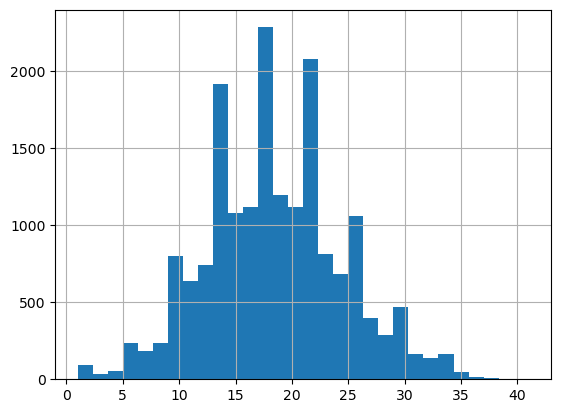

In [43]:
# check how the distribution has changed
rides_df['duration'].hist(bins=30)

The distribution has not changed significantly. Now let's look at long trips.  

In [44]:
rides_df.query('duration > 30').sort_values(by='duration',ascending=False)

,user_id,distance,duration,date,month,speed
4215,454,5137.327103,41.0,2021-12-27,12,7.550458
4709,507,4645.642671,40.0,2021-01-15,1,6.990509
2623,278,4754.433686,40.0,2021-12-02,12,7.217064
1998,216,4831.339954,39.0,2021-05-11,5,7.558266
143,15,4187.621459,39.0,2021-01-13,1,6.590229
...,...,...,...,...,...,...
5472,584,4064.070502,31.0,2021-07-05,7,8.042262
13259,1194,4403.572355,31.0,2021-04-29,4,8.801428
5459,583,4022.815345,31.0,2021-09-01,9,8.009085
5432,581,4535.778366,31.0,2021-01-15,1,8.870813


Everything looks realistic.
But the peak of very short distances is still unexplained, so let's take a closer look at these trips.  

In [45]:
rides_df.query('distance < 300').sort_values(by='distance')

,user_id,distance,duration,date,month,speed
11555,1069,0.855683,11.0,2021-01-31,1,0.005133
9541,925,2.570787,4.0,2021-10-19,10,0.051228
13690,1223,4.329506,5.0,2021-05-22,5,0.064797
8658,861,6.784447,7.0,2021-07-21,7,0.067668
7841,796,7.097072,11.0,2021-11-26,11,0.042469
...,...,...,...,...,...,...
9687,937,297.735766,11.0,2021-04-17,4,1.632888
12877,1165,298.333364,7.0,2021-12-04,12,2.627085
15435,1350,298.416121,13.0,2021-11-22,11,1.477422
13224,1192,298.586489,7.0,2021-04-14,4,2.688545


In [46]:
len(rides_df.query('distance < 200'))/len(rides_df) * 100

0.9408899712198361

* A trip lasting 10 minutes with a distance of less than one meter looks anomalous.  
* Such cases are hard to consider as real trips — most likely, the scooter was taken and then the trip ended immediately for some reason.  
* These values can also be removed.  
* Other short trips can be kept, since they do not make up a large share of the data and may reflect users taking scooters just to "try them out." Additionally, users with free start conditions may take very short trips.  

In [47]:
rides_df = rides_df.query('duration > 2 and distance > 200')
rides_df.reset_index(drop=True)

,user_id,distance,duration,date,month,speed
0,1,4409.919140,26.0,2021-01-01,1,10.335841
1,1,2617.592153,16.0,2021-01-18,1,9.929620
2,1,754.159807,7.0,2021-04-20,4,7.260713
3,1,2694.783254,19.0,2021-08-11,8,8.734644
4,1,4028.687306,27.0,2021-08-28,8,9.202888
...,...,...,...,...,...,...
17798,1534,3781.098080,20.0,2021-11-04,11,11.444601
17799,1534,2840.423057,22.0,2021-11-16,11,7.960158
17800,1534,3826.185507,19.0,2021-11-18,11,12.452969
17801,1534,2902.308661,17.0,2021-11-27,11,10.443489


##### Conclusion for this section:

1. The service is almost equally popular in all represented cities.  
2. Users with a subscription are only 10% fewer than those without, indicating a solid base of regular customers.  
3. Most users are between 22 and 28 years old.  
4. Most trips cover a distance of 2500 to 3800 meters.  
5. On average, a trip lasts 18 minutes.  

#### Step 4. Data Merging

In [48]:
print('Users dataset size:', len(user_df), 'rows')
print('Rides dataset size:', len(rides_df), 'rows')

Users dataset size: 1534 rows
Rides dataset size: 17803 rows


In [49]:
# merge the users table with subscription information  
# perform a left join, since it is more relevant to keep trips by users
user_data = user_df.merge(rides_df, on='user_id', how='left')
user_data.sort_values(by='date').head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,10.335841
2708,289,Алла,28,Ростов-на-Дону,ultra,2682.127506,12.0,2021-01-01,1,14.222640
16388,1431,Яна,26,Екатеринбург,free,3926.896437,23.0,2021-01-01,1,10.592203
16405,1432,Федор,23,Тюмень,free,2239.289899,19.0,2021-01-01,1,7.312247
2356,251,Василий,20,Сочи,ultra,3194.074357,12.0,2021-01-01,1,16.911246
14254,1275,Виталина,26,Тюмень,free,805.764950,16.0,2021-01-01,1,3.128520
2037,220,Тимофей,31,Омск,ultra,3142.127676,12.0,2021-01-01,1,16.837555
6920,730,Анна,28,Омск,free,5181.449644,26.0,2021-01-01,1,11.996696
2754,294,Елизавета,25,Екатеринбург,ultra,3213.683882,24.0,2021-01-01,1,8.364861
16851,1467,Тимур,32,Екатеринбург,free,1875.822964,17.0,2021-01-01,1,7.017126


In [50]:
print('First merged dataset size:', len(user_data), 'rows')

First merged dataset size: 17803 rows


In [51]:
print('Subscriptions dataset size:', len(subs_df), 'rows')

Subscriptions dataset size: 2 rows


In [52]:
data = user_data.merge(subs_df, on='subscription_type', how='left')
data.duplicated().sum()
data.sort_values(by='date').head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,10.335841,6,0,199
2708,289,Алла,28,Ростов-на-Дону,ultra,2682.127506,12.0,2021-01-01,1,14.222640,6,0,199
16388,1431,Яна,26,Екатеринбург,free,3926.896437,23.0,2021-01-01,1,10.592203,8,50,0
16405,1432,Федор,23,Тюмень,free,2239.289899,19.0,2021-01-01,1,7.312247,8,50,0
2356,251,Василий,20,Сочи,ultra,3194.074357,12.0,2021-01-01,1,16.911246,6,0,199


In [53]:
print('Final merged dataset size:', len(data), 'rows')

Final merged dataset size: 17803 rows


In [54]:
ultra_users = data.query('subscription_type == "ultra"')
free_users = data.query('subscription_type == "free"')

Let’s look at distance and trip duration data for users of both categories.

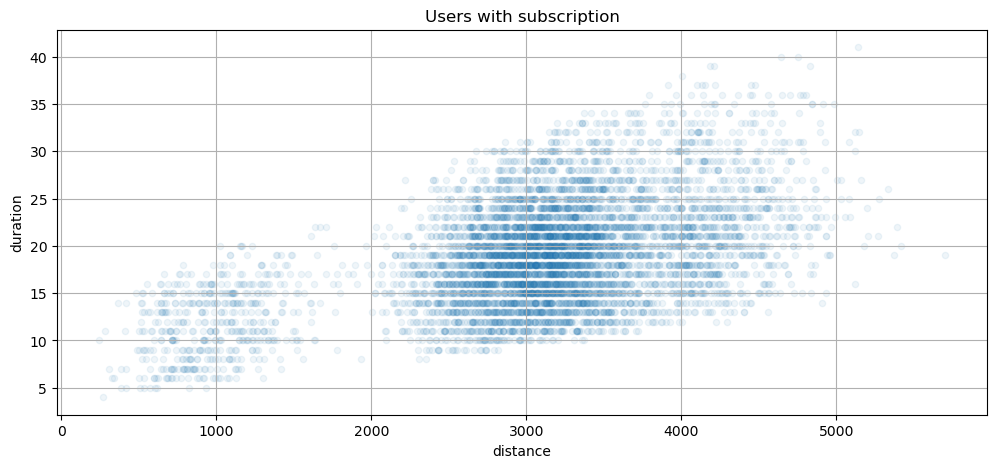

<Axes: title={'center': 'Users without subscription'}, xlabel='distance', ylabel='duration'>

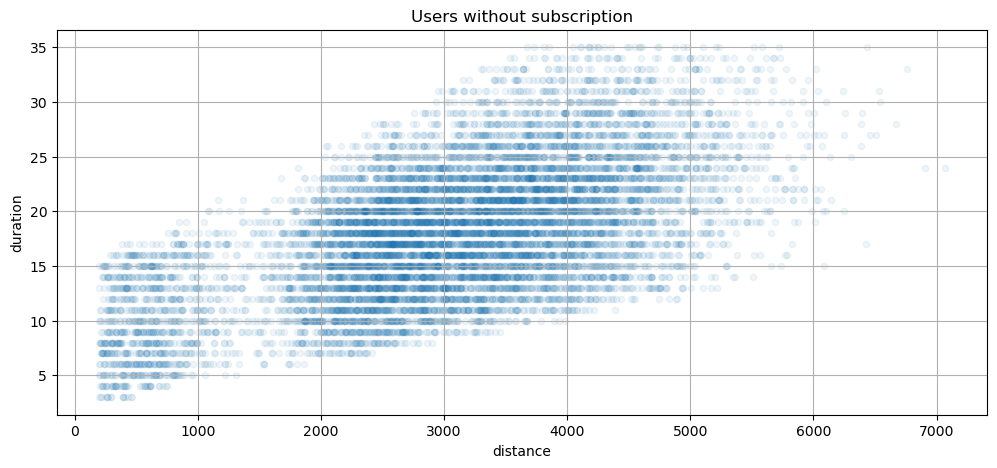

In [55]:
ultra_users.plot(
    y='duration', x='distance',
    grid=True, figsize=(12, 5),
    kind='scatter', alpha=0.07,
    title='Users with subscription'
)
plt.show()

free_users.plot(
    y='duration', x='distance',
    grid=True, figsize=(12, 5),
    kind='scatter', alpha=0.07,
    title='Users without subscription'
)

**Conclusion:**  
1. The first chart shows that users with a subscription have more centralized average values, meaning their usage behavior is more predictable.  
2. Both categories show two peaks in trip duration, but for non-subscribers the peaks are more pronounced. This suggests that free users more often take "short" trips, which can be considered "trial" rides.  
3. Ultra users typically travel 2.5–3.5 km with an average duration of 20 minutes.  
4. Free users average 2–4 km trips with a duration of 20 minutes.  
5. Ultra users almost never take 2 km trips. This suggests they mainly use scooters for longer, regular trips (e.g., commuting), where the service replaces other transport.  
6. Free users show less predictable behavior, with more chaotic trip patterns.  

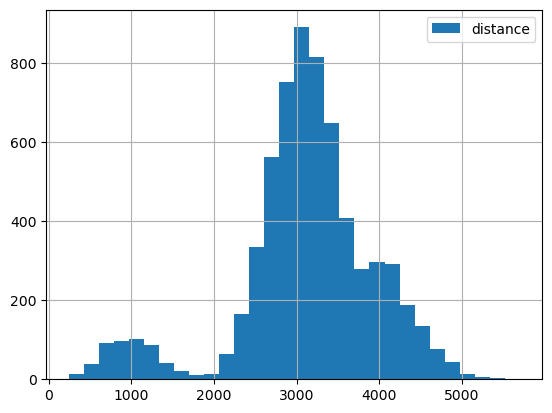

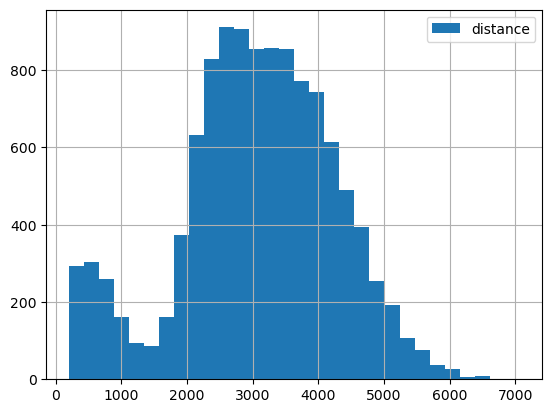

In [56]:
ultra_users['distance'].hist(bins=30, legend = True);
plt.show();
free_users['distance'].hist(bins=30, legend = True);

**Conclusion:**  
1. The first chart shows that subscribed users have two distinct peaks: short trips of about 1 km and longer trips of about 3 km. Short trips are noticeably fewer compared to non-subscribers.  
2. Non-subscribers have a wider range of average distances: from 2 km to 3.5 km.  

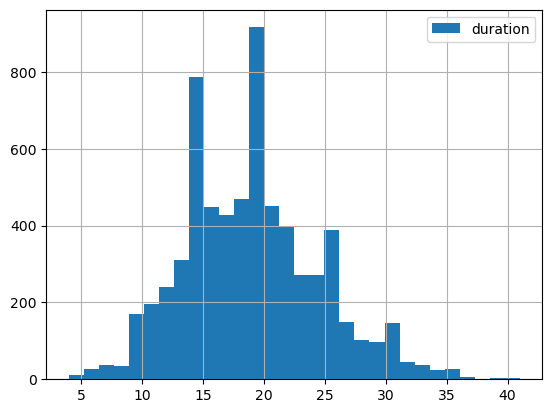

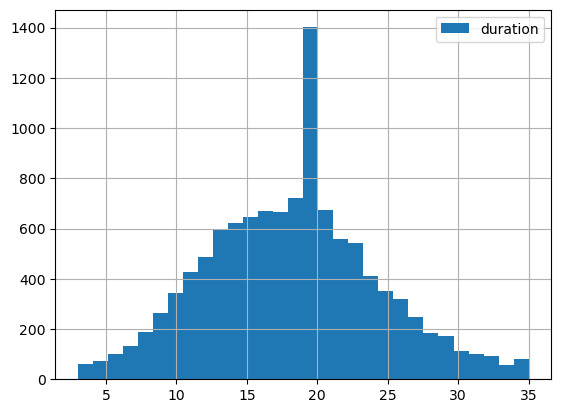

In [57]:
ultra_users['duration'].hist(bins=30, legend = True);
plt.show();
free_users['duration'].hist(bins=30, legend = True);

**Conclusion:**  
1. The first chart shows that subscribed users have three distinct peaks in trip duration: around 15 minutes, 20 minutes, and 25 minutes.  
2. Non-subscribers have one distinct peak at 20 minutes.  

##### Conclusion for this section:
1. A merged dataset was created from the three original sources.  
2. Subscribed users show more predictable behavior in using the service.  
3. Subscribed users on average travel longer distances than non-subscribers.  
4. Users in both categories typically take trips of about 20 minutes.  
5. Subscribed users make fewer "short" trips (under 1 km).  

#### Step 5. Revenue Calculation

In [58]:
ultra_agg_data = (ultra_users
    .groupby(['user_id','month'])['distance','duration']
    .aggregate({'distance': ['sum', 'count'], 'duration': 'sum'})
           )

ultra_agg_data.columns = ['distance_total','total_rides','duration_total']


/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_47700/4039674242.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ultra_agg_data = (ultra_users


In [61]:
# check the aggregated dataset  
ultra_agg_data.isna().sum()

distance_total    0
total_rides       0
duration_total    0
dtype: int64

In [59]:
free_agg_data = (ultra_users
    .groupby(['user_id','month'])['distance','duration']
    .aggregate({'distance': ['sum', 'count'], 'duration': 'sum'})
           )

free_agg_data.columns = ['distance_total','total_rides','duration_total']

/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_47700/4182432179.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  free_agg_data = (ultra_users


In [60]:
# check the aggregated dataset  
free_agg_data.isna().sum()

distance_total    0
total_rides       0
duration_total    0
dtype: int64

In [79]:
ultra_agg_data['income'] = (ultra_agg_data['duration_total'] * 6) + 199
free_agg_data['income'] = (free_agg_data['duration_total'] * 8) + (50 * free_agg_data['total_rides'])

In [80]:
ultra_agg_data.head(15)

distance_total  total_rides  duration_total  income
user_id month                                                     
1       1         7027.511294            2            42.0   451.0
        4          754.159807            1             7.0   241.0
        8         6723.470560            2            46.0   475.0
        10        5809.911100            2            32.0   391.0
        11        7003.499363            3            56.0   535.0
        12        6751.629942            2            28.0   367.0
2       3        10187.723006            3            63.0   577.0
        4         6164.381824            2            40.0   439.0
        6         3255.338202            1            14.0   283.0
        7         6780.722964            2            48.0   487.0
        8          923.007439            1             7.0   241.0
        10        2824.636598            1            19.0   313.0
        12        3828.248580            1            12.0   271.0
3       1         3061.777147            1            13.0   277.0
        2         5421.152016            2            39.0   433.0

In [81]:
free_agg_data.head(15)

distance_total  total_rides  duration_total  income
user_id month                                                     
1       1         7027.511294            2            42.0   436.0
        4          754.159807            1             7.0   106.0
        8         6723.470560            2            46.0   468.0
        10        5809.911100            2            32.0   356.0
        11        7003.499363            3            56.0   598.0
        12        6751.629942            2            28.0   324.0
2       3        10187.723006            3            63.0   654.0
        4         6164.381824            2            40.0   420.0
        6         3255.338202            1            14.0   162.0
        7         6780.722964            2            48.0   484.0
        8          923.007439            1             7.0   106.0
        10        2824.636598            1            19.0   202.0
        12        3828.248580            1            12.0   146.0
3       1         3061.777147            1            13.0   154.0
        2         5421.152016            2            39.0   412.0

In [82]:
len(ultra_agg_data) + len(free_agg_data)

9066

#### Step 6. Hypothesis Testing

##### Do subscribed users spend more time on trips?

In [83]:
free_users['duration'].mean()

18.16924710253915

Null hypothesis (H0): The average trip duration of subscribed and non-subscribed users is the same.  

Alternative hypothesis (H1): Subscribed users spend more time on trips on average than non-subscribed users.  

In [84]:
# interested_value = 18  # average trip duration of non-subscribers
# ultra_dur_value = np.ceil(free_users['duration'].mean()))

alpha = 0.05

results = st.ttest_ind(
    ultra_users['duration'],
    free_users['duration'],
    alternative='greater'
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 2.041575463826279e-21
Reject the null hypothesis


**Conclusion:** Subscribed users spend more time on trips than non-subscribers.

##### Is a trip distance of 3130 meters optimal in terms of scooter wear and tear?


H0: The average trip distance of subscribed users = 3130 m.  
H1: The average trip distance of subscribed users < 3130 m. 

In [85]:
interested_value = 3130

alpha = 0.05

results = st.ttest_1samp(
    ultra_users['distance'], 
    interested_value, alternative = 'greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 0.9195368847849785
Failed to reject the null hypothesis


**Conclusion:** Trips of subscribed users do not exceed the distance that leads to increased scooter wear.  

##### Will the monthly revenue from subscribed users be higher than from non-subscribed users?

Null hypothesis (H0): Monthly revenue from subscribed users = Monthly revenue from non-subscribed users.  

Alternative hypothesis (H1): Monthly revenue from subscribed users > Monthly revenue from non-subscribed users. 

In [86]:
sample_1 = ultra_agg_data['income']
sample_2 = free_agg_data['income']

alpha = 0.05

results = st.ttest_ind(sample_1, sample_2, alternative = 'greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 6.573708436400166e-168
Reject the null hypothesis


In [87]:
ultra_agg_data['income']

user_id  month
1        1        451.0
         4        241.0
         8        475.0
         10       391.0
         11       535.0
                  ...  
699      6        301.0
         8        469.0
         9        385.0
         10       295.0
         12       355.0
Name: income, Length: 4533, dtype: float64

**Conclusion:** Monthly revenue from subscribed users is greater than from non-subscribed users.  

##### Additional question:  

The technical team updated the servers that interact with the mobile app. They expect that the number of support requests has significantly decreased as a result. A file contains, for each user, data on the number of requests before and after the update. Which test would you use to check this hypothesis?  

**Answer:** A test for equality of means for dependent (paired) samples. Method: `scipy.stats.ttest_rel()`. Two equal-sized datasets (before and after the update) should be compared.  

##### Conclusion for this section:  

1. Subscribed users spend more time on trips than non-subscribers. Increasing the number of subscribers may raise the average trip duration. However, there is also reason to assume that a higher number of subscribers could lead to scooter shortages due to longer trips.  
2. Subscribed users’ trips do not exceed the distance that causes increased scooter wear. There is no reason to assume that regular customers wear out scooters more.  
3. Monthly revenue from subscribed users is higher than from non-subscribers. Increasing the number of subscribers is reasonable from a profit perspective.  

#### Step 7. Distributions

**Promo Code Task**

<BarContainer object of 36 artists>

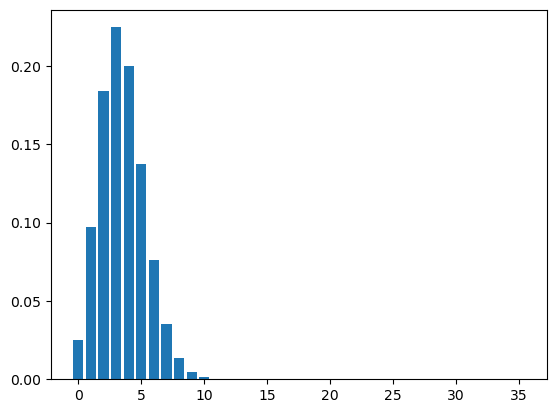

In [88]:
p = 0.1  # probability of signing a contract (success probability)
n = 35   # how many promo codes to send (number of trials)

# create list distr to store distribution values
distr = []

for k in range(0, n+1):
    choose = factorial(n) / (factorial(k) * factorial(n-k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)  # probability of event
    
# plot probability distribution histogram
plt.bar(range(0, n+1), distr)

**Conclusion:** Promo codes should be sent to at least 35 users.

#### Step 8. Project Conclusion  

1. Two types of analysis were conducted: exploratory and statistical.  

2. As part of the exploratory analysis, the following was identified:  
* The service is almost equally popular in all represented cities. The difference between the most popular city (Pyatigorsk) and the least (Moscow) is less than 5%.  
* Non-subscribers make up 54%, while subscribers account for 45%.  
* Most users are between 22 and 28 years old.  
* Most trips cover 2500 to 3800 meters.  
* On average, a trip lasts 18 minutes.  

3. As part of the statistical analysis, 3 hypotheses were tested. It was found that:  
* Subscribed users spend more time on trips than non-subscribers.  
* At the same time, the trips of subscribed users do not exceed the distance that would lead to increased scooter wear.  
* Revenue from subscribed users is higher than from non-subscribers. Increasing the number of subscribers is reasonable from a profit perspective.  